In [1]:
# Section 1: Import libraries and set paths

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from scipy.interpolate import interp1d
from tensorflow.keras import layers, models

# Path to training .csv files
DATA_DIR = "./data/training_curves"

# Check if directory exists
if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError(f"The specified directory does not exist: {DATA_DIR}")

# Check if there are any .csv files in the directory
curve_files = glob(os.path.join(DATA_DIR, "*.csv"))

if len(curve_files) == 0:
    raise FileNotFoundError(f"No .csv files found in directory: {DATA_DIR}")

print(f"Found {len(curve_files)} .csv files in {DATA_DIR}")

Found 100 .csv files in ./data/training_curves


In [2]:
# Section 2: Load indentation curves and extract load vs. depth between "Surface Index" and "End Of Loading Index"

def load_curve_from_csv(file_path):
    df = pd.read_csv(file_path, skiprows=[1], sep=",")  # skip unit row
    marker_col = df.columns[0]

    # Find indices for Surface and End Of Loading
    try:
        surface_idx = df.index[df[marker_col] == "Surface Index"].tolist()[0]
        end_idx = df.index[df[marker_col] == "End Of Loading Index"].tolist()[0]
    except IndexError:
        print(f"Skipping {file_path} due to missing markers.")
        return None

    # Extract relevant portion of the curve
    df_section = df.loc[surface_idx:end_idx].copy()
    df_section = df_section.dropna(subset=["LOAD", "DEPTH"])

    depth = df_section["DEPTH"].astype(float).values
    load = df_section["LOAD"].astype(float).values

    return depth, load

# Load all curves
curve_files = glob(os.path.join(DATA_DIR, "*.csv"))
curves = []

for f in curve_files:
    result = load_curve_from_csv(f)
    if result:
        curves.append(result)

In [3]:
# Section 3: Normalize and resample each curve to a fixed number of points (e.g. 512)

from scipy.signal import savgol_filter

N_POINTS = 512

def normalize_and_interpolate(depth, load, n_points=N_POINTS, smoothing=False):
    sorted_idx = np.argsort(depth)
    depth = depth[sorted_idx]
    load = load[sorted_idx]

    new_depth = np.linspace(np.min(depth), np.max(depth), n_points)
    interp_fn = interp1d(depth, load, kind='linear', fill_value="extrapolate")
    new_load = interp_fn(new_depth)

    # Smoothing disattivato nel training
    if smoothing:
        new_load = savgol_filter(new_load, window_length=11, polyorder=3)

    new_load = (new_load - np.mean(new_load)) / np.std(new_load)
    return new_load

X_data = np.array([normalize_and_interpolate(d, l) for d, l in curves])
X_data = X_data[..., np.newaxis]  # shape: (N, 512, 1)

print("Dataset shape:", X_data.shape)

Dataset shape: (100, 512, 1)


In [4]:
# Section 3b: Visualize load–depth curves (normalized)

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interactive_training_curve_viewer(X_data):
    """
    Interactive viewer for normalized training curves using a slider.
    """

    def plot_curve(i):
        curve = X_data[i].squeeze()
        plt.figure(figsize=(8, 4))
        plt.plot(curve, label=f"Curve #{i}", linewidth=1.5)
        plt.xlabel("Normalized depth index")
        plt.ylabel("Normalized load")
        plt.title(f"Training curve #{i}")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(X_data) - 1,
        step=1,
        description='Curve:',
        continuous_update=False
    )

    widgets.interact(plot_curve, i=slider)

# Esegui questo blocco per visualizzare le curve una per una
interactive_training_curve_viewer(X_data)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Curve:', max=99), Output()), _d…

In [5]:
# Section 4: Define 1D convolutional autoencoder

input_signal = layers.Input(shape=(N_POINTS, 1))

# Encoder
x = layers.Conv1D(32, 5, activation='relu', padding='same')(input_signal)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
encoded = layers.MaxPooling1D(2)(x)

# Decoder
x = layers.Conv1D(64, 5, activation='relu', padding='same')(encoded)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 5, activation='linear', padding='same')(x)

autoencoder = models.Model(input_signal, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 512, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 256, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 256, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 128, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 256, 32)        │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 512, 1)         │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,473 (162.00 KB)

 Trainable params: 41,473 (162.00 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Section 5: Train autoencoder

history = autoencoder.fit(X_data, X_data,
                          epochs=50,
                          batch_size=16,
                          validation_split=0.1)
autoencoder.save("models/autoencoder.keras")

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.8263 - val_loss: 0.2486
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1614 - val_loss: 0.1234
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0949 - val_loss: 0.0335
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0386 - val_loss: 0.0282
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0207 - val_loss: 0.0171
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0123 - val_loss: 0.0097
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0075 - val_loss: 0.0056
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0014 - val_loss: 0.0011
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


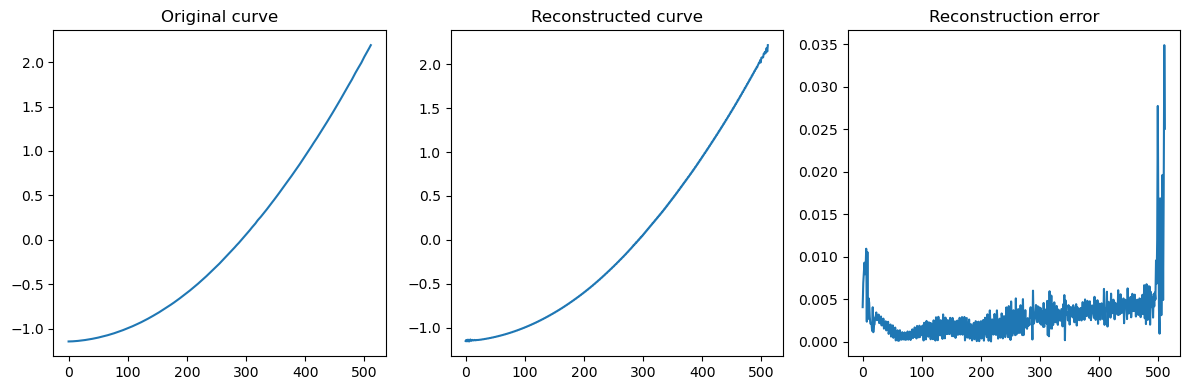

In [7]:
# Section 6: Visualize reconstruction and compute error

def plot_reconstruction(idx):
    original = X_data[idx].squeeze()
    reconstructed = autoencoder.predict(X_data[idx:idx+1])[0].squeeze()

    error = np.abs(original - reconstructed)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(original, label="Original")
    plt.title("Original curve")

    plt.subplot(1, 3, 2)
    plt.plot(reconstructed, label="Reconstructed")
    plt.title("Reconstructed curve")

    plt.subplot(1, 3, 3)
    plt.plot(error, label="Error")
    plt.title("Reconstruction error")

    plt.tight_layout()
    plt.show()

# Try with a few curves
plot_reconstruction(0)

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tensorflow.keras.models import load_model

FILE_PATH = "./data/evaluation_data.xlsx"

def load_curves_from_excel(file_path):
    xl = pd.ExcelFile(file_path)
    results = []

    for sheet in xl.sheet_names:
        if not sheet.lower().startswith("test"):
            continue

        try:
            # Carica il foglio saltando la riga delle unità (seconda riga, indice 1)
            df = xl.parse(sheet, skiprows=[1])
            df.columns = df.columns.str.strip()  # rimuove spazi nei nomi delle colonne

            marker_col = df.columns[0]
            df[marker_col] = df[marker_col].astype(str).str.strip()

            if not df[marker_col].str.contains("Surface Index").any():
                continue
            if not df[marker_col].str.contains("End Of Loading Index").any():
                continue

            i_start = df[df[marker_col].str.contains("Surface Index")].index[0]
            i_end = df[df[marker_col].str.contains("End Of Loading Index")].index[0]
            if i_end <= i_start:
                continue

            df_curve = df.loc[i_start:i_end].copy()

            # Conversione a float e gestione colonne
            df_curve["DEPTH"] = df_curve["DEPTH"].astype(float)
            df_curve["LOAD"] = df_curve["LOAD"].astype(float)

            depth = df_curve["DEPTH"].values
            load = df_curve["LOAD"].values
            time = df_curve["Time On Sample"].astype(float).values

            results.append((sheet, depth, load, time))

        except Exception as e:
            print(f"Error processing sheet {sheet}: {e}")
            continue

    return results

In [46]:
curves = load_curves_from_excel("./data/evaluation_data.xlsx")
print(f"Loaded {len(curves)} curves")

# Verifica struttura prima curva
sheet, depth, load, time = curves[0]
print("Sheet:", sheet)
print("Depth shape:", depth.shape)
print("Load shape:", load.shape)
print("Time shape:", time.shape)

Loaded 400 curves
Sheet: Test 1
Depth shape: (509,)
Load shape: (509,)
Load shape: (509,)


In [47]:
from scipy.signal import savgol_filter

N_POINTS = 512

def normalize_and_interpolate(depth, load, time, n_points=N_POINTS):
    sorted_idx = np.argsort(depth)
    depth = depth[sorted_idx]
    load = load[sorted_idx]
    time = time[sorted_idx]

    new_depth = np.linspace(np.min(depth), np.max(depth), n_points)

    interp_load = interp1d(depth, load, kind='linear', fill_value="extrapolate")(new_depth)
    interp_time = interp1d(depth, time, kind='linear', fill_value="extrapolate")(new_depth)

    norm_load = (interp_load - np.mean(interp_load)) / np.std(interp_load)
    return norm_load, interp_time

In [48]:
# Load previously trained autoencoder model
MODEL_PATH = "./models/autoencoder.keras"
autoencoder = load_model(MODEL_PATH)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 512, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 256, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 256, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 128, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 256, 32)        │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 512, 1)         │           161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,421 (486.02 KB)

 Trainable params: 41,473 (162.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 82,948 (324.02 KB)

In [52]:
results = []

ERROR_THRESHOLD = 0.02  # soglia fissa
DEPTH_MIN = 20          # nm
DEPTH_MAX_FRAC = 0.95    # percentuale della max depth

results = []

for sheet, depth, load, time in curves:
    norm_curve, time_interp = normalize_and_interpolate(depth, load, time)
    inp = norm_curve.reshape(1, -1, 1)
    recon = autoencoder.predict(inp, verbose=0)[0].squeeze()
    error = np.abs(norm_curve - recon)

    # Ricostruzione della profondità interpolata
    sorted_idx = np.argsort(depth)
    depth_sorted = depth[sorted_idx]
    depth_interp = np.linspace(np.min(depth_sorted), np.max(depth_sorted), len(norm_curve))

    # Maschera per intervallo depth fidato
    mask = (depth_interp > DEPTH_MIN) & (depth_interp < DEPTH_MAX_FRAC * np.max(depth_interp))

    # Applica soglia fissa sull'intervallo fidato
    popin_idx = np.where((error > ERROR_THRESHOLD) & mask)[0]

    results.append({
        "sheet": sheet,
        "curve": norm_curve,
        "reconstruction": recon,
        "error": error,
        "depth_interp": depth_interp,
        "popin_idx": popin_idx,
        "threshold": ERROR_THRESHOLD
    })

In [53]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interactive_popin_viewer(results):
    """
    Interactively visualize autoencoder results:
    - original vs reconstructed curve
    - reconstruction error with detected pop-ins
    - pop-in positions on the original curve
    """

    def plot_curve(i):
        r = results[i]
        curve = r["curve"]
        recon = r["reconstruction"]
        error = r["error"]
        popin_idx = r["popin_idx"]
        sheet = r["sheet"]

        fig, axs = plt.subplots(1, 3, figsize=(16, 4))

        axs[0].plot(curve, label="Original")
        axs[0].plot(recon, label="Reconstructed", linestyle="--")
        axs[0].set_title(f"{sheet} – Input vs Reconstruction")
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(error, label="Error", color="orange")
        axs[1].scatter(popin_idx, error[popin_idx], color="red", s=10)
        axs[1].set_title("Reconstruction Error")
        axs[1].legend()
        axs[1].grid(True)

        axs[2].plot(curve, label="Original")
        axs[2].scatter(popin_idx, curve[popin_idx], color="red", s=10, label="Pop-in")
        axs[2].set_title("Detected Pop-ins")
        axs[2].legend()
        axs[2].grid(True)

        plt.tight_layout()
        plt.show()

    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(results) - 1,
        step=1,
        description='Curve:',
        continuous_update=False
    )

    widgets.interact(plot_curve, i=slider)

# Exeute to see the results
interactive_popin_viewer(results)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Curve:', max=399), Output()), _…

In [54]:
from itertools import groupby
from operator import itemgetter

def group_consecutive(indices, min_gap=1):
    """
    Raggruppa indici consecutivi in gruppi (es. pop-in multipli).
    min_gap: numero minimo di punti tra due eventi distinti
    """
    grouped = []
    for k, g in groupby(enumerate(indices), lambda x: x[0] - x[1]):
        group = list(map(itemgetter(1), g))
        if len(group) > 1:
            grouped.append(group)
    return grouped

In [55]:
for r in results:
    depth = r["depth_interp"]
    load = r["curve"]
    popin_groups = group_consecutive(r["popin_idx"])

    events = []
    for group in popin_groups:
        i_start = group[0]
        i_end = group[-1]

        d_depth = depth[i_end] - depth[i_start]
        d_load = load[i_end] - load[i_start]

        # Assumendo acquisizione uniforme → può essere anche in frame
        velocity = d_load / d_depth if d_depth != 0 else np.nan

        events.append({
            "start": i_start,
            "end": i_end,
            "depth_start": depth[i_start],
            "depth_end": depth[i_end],
            "load_start": load[i_start],
            "load_end": load[i_end],
            "delta_depth": d_depth,
            "delta_load": d_load,
            "velocity": velocity
        })

    r["popin_events"] = events

In [56]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def plot_popin_events(results):
    def view(i):
        r = results[i]
        curve = r["curve"]
        depth = r["depth_interp"]
        sheet = r["sheet"]
        popin_events = r.get("popin_events", [])

        plt.figure(figsize=(10, 5))
        plt.plot(depth, curve, label="Normalized Load", color="black")
        plt.title(f"Curve: {sheet}")
        plt.xlabel("Depth (nm)")
        plt.ylabel("Normalized Load")
        plt.grid(True)

        for ev in popin_events:
            i_start, i_end = ev["start"], ev["end"]
            x = depth[i_start:i_end+1]
            y = curve[i_start:i_end+1]

            plt.plot(x, y, color="red", lw=2, label="Pop-in" if ev == popin_events[0] else "")

            # Annotate with load jump and velocity
            if not np.isnan(ev["velocity"]):
                x_txt = depth[(i_start + i_end) // 2]
                y_txt = curve[(i_start + i_end) // 2]
                txt = f"ΔL={ev['delta_load']:.2f} mN\nv={ev['velocity']:.2f} mN/s"
                plt.annotate(txt, (x_txt, y_txt), textcoords="offset points", xytext=(5, 5), fontsize=9, color="darkred")

        plt.legend()
        plt.tight_layout()
        plt.show()

    slider = widgets.IntSlider(0, 0, len(results)-1, step=1, description="Curve")
    widgets.interact(view, i=slider)

# Call this to launch the interactive plot
plot_popin_events(results)

interactive(children=(IntSlider(value=0, description='Curve', max=399), Output()), _dom_classes=('widget-inter…

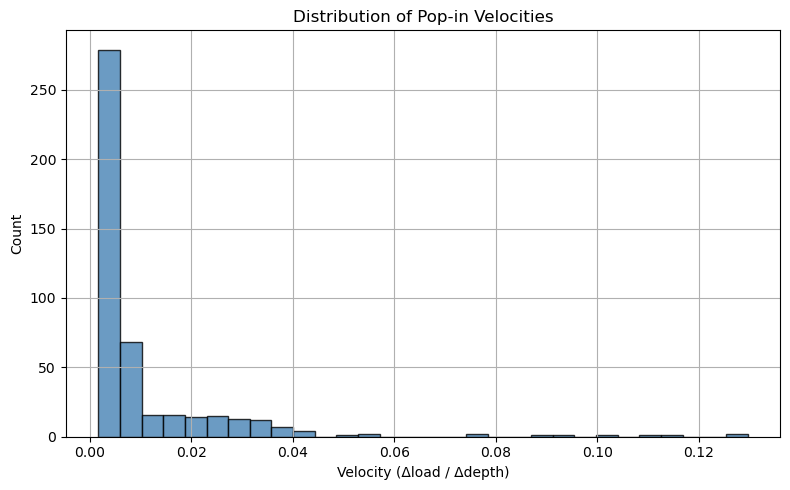

In [57]:
import matplotlib.pyplot as plt

# Extract all velocities from all curves
all_velocities = []

for r in results:
    events = r.get("popin_events", [])
    for ev in events:
        if not np.isnan(ev["velocity"]):
            all_velocities.append(ev["velocity"])

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_velocities, bins=30, color="steelblue", edgecolor="black", alpha=0.8)
plt.title("Distribution of Pop-in Velocities")
plt.xlabel("Velocity (Δload / Δdepth)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()